In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train[y_train <= 1]
y_train = y_train[y_train <= 1]
x_test = x_test[y_test <= 1]
y_test = y_test[y_test <= 1]

In [3]:
print(f"Dimensions of x_train: {x_train.shape}")
print(f"Dimensions of y_train: {y_train.shape}")
print(f"Dimensions of x_test: {x_test.shape}")
print(f"Dimensions of y_test: {y_test.shape}")

Dimensions of x_train: (12665, 28, 28)
Dimensions of y_train: (12665,)
Dimensions of x_test: (2115, 28, 28)
Dimensions of y_test: (2115,)


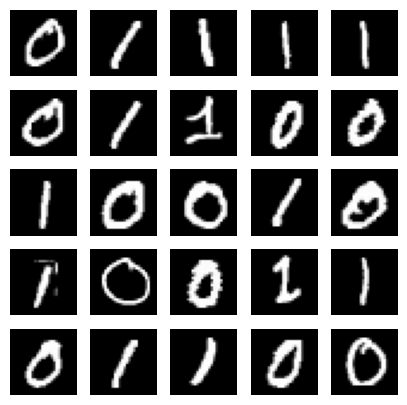

In [4]:
# sample 25 mnist digits from train dataset
indexes = np.arange(0, 25)
images = x_train[indexes]
labels = y_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

In [5]:
# x_train.shape : (12665, 28, 28)
# x_train reshape to (784,12665)

X_train = x_train.reshape(x_train.shape[0],-1).T
X_test = x_test.reshape(x_test.shape[0],-1).T

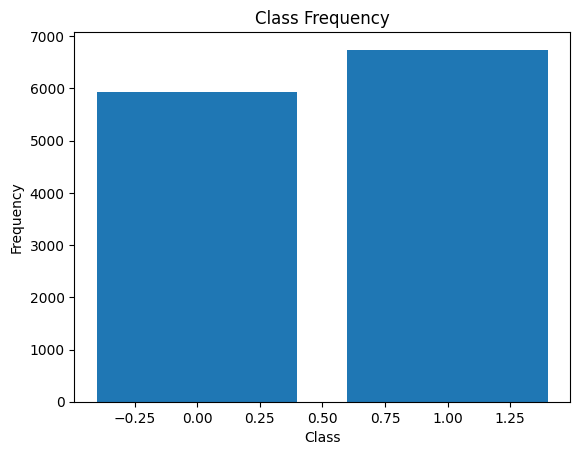

In [6]:
# make a graph plotting the number of samples for each class
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()



In [7]:
def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu_prime(z):
    return z > 0

In [8]:
def initialize_parameters(n_x,n_h1,n_h2,n_y):
    """
    Initializes the parameters of a neural network model.
    
    Arguments:
    n_x -- size of the input layer
    n_h1 -- size of the first hidden layer
    n_h2 -- size of the second hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- a dictionary containing the initialized parameters:
                    W1 -- weight matrix of shape (n_h1, n_x)
                    b1 -- bias vector of shape (n_h1, 1)
                    W2 -- weight matrix of shape (n_h2, n_h1)
                    b2 -- bias vector of shape (n_h2, 1)
                    W3 -- weight matrix of shape (n_y, n_h2)
                    b3 -- bias vector of shape (n_y, 1)
    """
    W1 = np.random.rand(n_h1,n_x) * 0.01
    b1 = np.zeros((n_h1,1))
    W2 = np.random.rand(n_h2,n_h1) * 0.01
    b2 = np.zeros((n_h2,1))
    W3 = np.random.rand(n_y,n_h2) * 0.01
    b3 = np.zeros((n_y,1))
    parameters = {
        'W1': W1,
        'W2' : W2,
        'b1' : b1,
        'b2' : b2,
        'W3' : W3,
        'b3' : b3
    }
    return parameters

def forward_linear(w,b,x):
    return np.dot(w,x) + b

def forward_prop(parameters,X):
    """
    Perform forward propagation for a neural network with given parameters and input data.

    Parameters:
    parameters (dict): Dictionary containing the weights and biases of the neural network.
    X (ndarray): Input data.

    Returns:
    A3 (ndarray): Output of the neural network after forward propagation.
    cache (dict): Dictionary containing the intermediate values computed during forward propagation.
    """
    
    W1, b1, W2,b2,W3,b3 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2'], parameters['W3'], parameters['b3']
    Z1 = forward_linear(W1,b1,X)
    A1 = relu(Z1)
    Z2 = forward_linear(W2,b2,A1)
    A2 = relu(Z2)
    Z3 = forward_linear(W3,b3,A2)
    A3 = sigmoid(Z3)
    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2,
        'Z3': Z3,
        'A3': A3
    }
    return A3, cache

def binary_cross_entropy(y_true, y_pred):
  y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)

  # Calculate BCE for each sample
  losses = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

  # Return the average loss
  return np.mean(losses)


In [9]:
def backprog(X, cache, actual, parameters):
    """
    Compute the gradients of the neural network parameters using backpropagation.

    Parameters:
    X (numpy.ndarray): Input data of shape (input_size, m).
    cache (dict): Dictionary containing the intermediate values computed during forward propagation.
    actual (numpy.ndarray): Actual output of shape (output_size, m).
    parameters (dict): Dictionary containing the parameters of the neural network.

    Returns:
    dict: Dictionary containing the gradients of the parameters.

    """

    A3, A2, A1 = cache['A3'], cache['A2'], cache['A1']
    W3, W2 = parameters['W3'], parameters['W2']
    m = X.shape[1] 

    # Output layer gradients
    dZ3 = A3 - actual
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m

    # Second hidden layer gradients
    dZ2 = np.dot(W3.T, dZ3) * (A2 > 0)
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    # First hidden layer gradients
    dZ1 = np.dot(W2.T, dZ2) * (A1 > 0)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    gradients = {"dW3": dW3, "db3": db3, "dW2": dW2, "db2": db2, "dW1": dW1, "db1": db1}

    return gradients


def update_parameters(parameters, gradients, learning_rate):
    parameters['W3'] -= learning_rate * gradients['dW3']
    parameters['b3'] -= learning_rate * gradients['db3']
    parameters['W2'] -= learning_rate * gradients['dW2']
    parameters['b2'] -= learning_rate * gradients['db2']
    parameters['W1'] -= learning_rate * gradients['dW1']
    parameters['b1'] -= learning_rate * gradients['db1']
    
    return parameters

In [10]:
parameters = initialize_parameters(784,128,64,1)

In [11]:
A3,cache = forward_prop(parameters,X_train)

### Dimensions are as follows:

- Dimension of W1: (128, 784)
- Dimension of W2: (64, 128)
- Dimension of W3: (1, 64)
- Dimension of b1: (128, 1)
- Dimension of b2: (64, 1)
- Dimension of b3: (1, 1)
- Dimension of Z1: (128, 12665)
- Dimension of A1: (128, 12665)
- Dimension of A2: (64, 12665)
- Dimension of A3: (1, 12665)

In [12]:
print(f"Dimension of W1: {parameters['W1'].shape}")
print(f"Dimension of W2: {parameters['W2'].shape}")
print(f"Dimension of W3: {parameters['W3'].shape}")
print(f"Dimension of b1: {parameters['b1'].shape}")
print(f"Dimension of b2: {parameters['b2'].shape}")
print(f"Dimension of b3: {parameters['b3'].shape}")
print(f"Dimension of Z1: {cache['Z1'].shape}")
print(f"Dimension of A1: {cache['A1'].shape}")
print(f"Dimension of Z2: {cache['Z2'].shape}")
print(f"Dimension of A2: {cache['A2'].shape}")
print(f"Dimension of Z3: {cache['Z3'].shape}")
print(f"Dimension of A3: {A3.shape}")
print(f"Dimensions of x_train: {X_train.shape}")
print(f"Dimensions of y_train: {y_train.shape}")
print(f"Dimensions of x_test: {X_test.shape}")
print(f"Dimensions of y_test: {y_test.shape}")

Dimension of W1: (128, 784)
Dimension of W2: (64, 128)
Dimension of W3: (1, 64)
Dimension of b1: (128, 1)
Dimension of b2: (64, 1)
Dimension of b3: (1, 1)
Dimension of Z1: (128, 12665)
Dimension of A1: (128, 12665)
Dimension of Z2: (64, 12665)
Dimension of A2: (64, 12665)
Dimension of Z3: (1, 12665)
Dimension of A3: (1, 12665)
Dimensions of x_train: (784, 12665)
Dimensions of y_train: (12665,)
Dimensions of x_test: (784, 2115)
Dimensions of y_test: (2115,)


In [13]:
def train_model(X, Y, parameters, learning_rate, num_iterations):
    for i in range(num_iterations+1):
        # Forward propagation
        A3,cache = forward_prop(parameters, X)
        
        # Compute cost
        cost = binary_cross_entropy(A3, Y)
        
        # Backpropagation
        gradients = backprog(X, cache, Y, parameters)
        
        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Print the cost every 100 iterations
        if i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
    return parameters

In [14]:
final_parameter = train_model(X_train, y_train, parameters, 0.01, 1000)

Cost after iteration 0: 7.538509452124427


C:\Users\arsha\AppData\Local\Temp\ipykernel_22536\619538025.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Cost after iteration 100: 3.816419190004349
Cost after iteration 200: 3.350894411702357
Cost after iteration 300: 2.961902710800798
Cost after iteration 400: 2.6365090951090746
Cost after iteration 500: 2.3641038707451116
Cost after iteration 600: 2.1346457004617303
Cost after iteration 700: 1.940198849647311
Cost after iteration 800: 1.773969400112113
Cost after iteration 900: 1.6310937191843216
Cost after iteration 1000: 1.507366425940045


In [15]:
def predict(X, parameters):
    # Forward propagation to get the predicted output
    A3,_ = forward_prop(X, parameters)
    
    # Convert the output probabilities to binary predictions (0 or 1)
    predictions = (A3 > 0.5).astype(int)
    
    return predictions


In [16]:
predictions = predict(final_parameter,X_test )

# Calculate accuracy
accuracy = np.mean(predictions == y_test)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


Test Accuracy: 99.95%


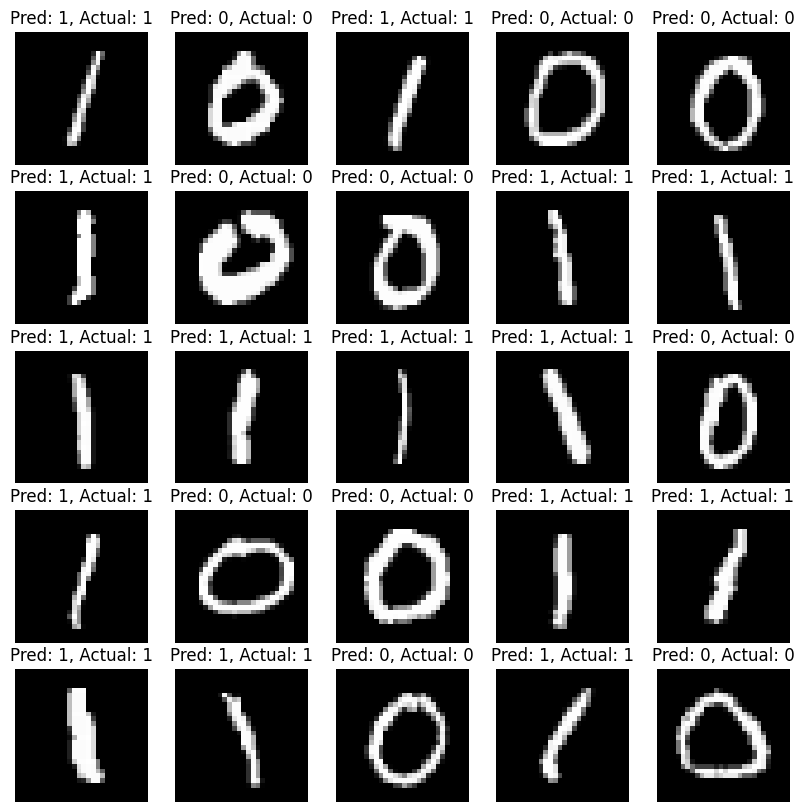

In [17]:
# Plot the first 25 test images, their predicted labels, and the true labels
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[:, i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Pred: {predictions[0, i]}, Actual: {y_test[i]}")
    ax.axis('off')
plt.show()

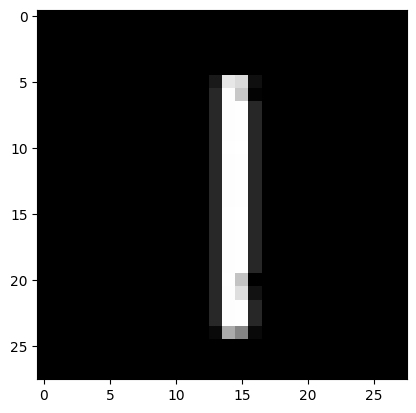

Prediction: 1
Actual: 1


In [18]:
# test on a single image of choice
index = 625
single_image = X_test[:, index].reshape(28, 28)
plt.imshow(single_image, cmap='gray')
plt.show()

# Make a prediction
prediction = predict(final_parameter,X_test[:, index].reshape(-1, 1))
print(f"Prediction: {prediction[0, 0]}")
print(f"Actual: {y_test[index]}")